In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import pairwise2

## Setup

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
hydrophobicity = {'G': 0, 'A': 41, 'L':97, 'M': 74, 'F':100, 'W':97, 'K':-23, 'Q':-10, 'E':-31, 'S':-5, 'P':-46, 'V':76, 'I':99, 'C':49, 'Y':63, 'H':8, 'R':-14, 'N':-28, 'D':-55, 'T':13}
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset & Sampling

In [3]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    ds = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        for peptide in peptides:
            ds.append((aptamer, peptide))
    ds = list(set(ds)) #removed duplicates
    return ds

# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S'(train/test) contains S_train/S_test with double the size of S_train/S_test
def get_S_prime(kind="train"):
    if kind == "train":
        dset = S_train
    else:
        dset = S_test
    k = len(dset)
    S_prime_dict = dict.fromkeys(dset, 0) #indicator 0 means in S
    for _ in range(k):
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in S
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()] 
    np.random.shuffle(S_prime)
    return S_prime

# S new contains unseen new examples
def get_S_new(k):
    S_new = []
    for i in range(k):
        pair = (get_x(), get_y())
        S_new.append(pair)
    np.random.shuffle(S_new)
    return S_new
    
# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf    

In [4]:
aptamer_dataset_file = "../data/aptamer_dataset.json"
S = construct_dataset()
n = len(S)
m = int(0.8*n) #length of S_train
S_train = S[:m]
S_test = S[m:]
S_prime_train = get_S_prime("train") #use for sgd 
S_prime_test = get_S_prime("test") #use for sgd 
S_new = get_S_new(10*n) #use for eval
train_ds = np.hstack((S_train, S_prime_train[:len(S_prime_train)//2]))

## NN Model

In [5]:
class ConvNetSimple(nn.Module):
    def __init__(self):
        super(Conv1dModelSimple, self).__init__()
        self.cnn_apt_1 = nn.Conv1d(40, 100, 3) 
        self.cnn_apt_2 = nn.Conv1d(100, 50, 1)
        
        self.cnn_pep_1 = nn.Conv1d(8, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 25, 1)
        self.cnn_pep_3 = nn.Conv1d(25, 10, 1)

        
        self.relu = nn.ReLU()
        self.name = "ConvNetSimple"
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, self.cnn_apt_2, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu, self.cnn_pep_2, self.relu)
        
        self.fc1 = nn.Linear(275, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [6]:
class LinearConv1dModel(nn.Module):
    def __init__(self):
        super(LinearConv1dModel, self).__init__()
        self.cnn_apt_1 = nn.Conv1d(40, 100, 3) 
        self.cnn_pep_1 = nn.Conv1d(8, 50, 3)

        self.relu = nn.ReLU()
        self.name = "LinearConv1dModel"
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(550, 1)
        self.conv_type = '1d'
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [7]:
class Conv1dModelSimple(nn.Module):
    def __init__(self):
        super(Conv1dModelSimple, self).__init__()
        self.cnn_apt_1 = nn.Conv1d(40, 100, 3) 
        self.cnn_apt_2 = nn.Conv1d(100, 50, 1)
        
        self.cnn_pep_1 = nn.Conv1d(8, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 25, 1)
        self.cnn_pep_3 = nn.Conv1d(25, 10, 1)

        
        self.relu = nn.ReLU()
        self.name = "Conv1dModelSimple"
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, self.cnn_apt_2, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu, self.cnn_pep_2, self.relu)
        
        self.fc1 = nn.Linear(275, 1)
        self.conv_type = '1d'
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [8]:
class LinearNet(nn.Module):
    def __init__(self):
        super(TrueLinearNet, self).__init__()
        self.lin_apt_1 = nn.Linear(160, 100) 
        self.lin_apt_2 = nn.Linear(100, 50)
        self.lin_apt_3 = nn.Linear(50, 10)
        
        self.lin_pep_1 = nn.Linear(160, 50)
        self.lin_pep_2 = nn.Linear(50, 10)

        self.relu = nn.ReLU()
        
        self.name = "LinearNet"
        
        self.lin_apt = nn.Sequential(self.lin_apt_1, self.lin_apt_2, self.lin_apt_3)
        self.lin_pep = nn.Sequential(self.lin_pep_1, self.lin_pep_2)
        
        self.fc1 = nn.Linear(20, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        apt = self.lin_apt(apt)
        pep = self.lin_pep(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [9]:
# This model is too complex for our input sequence size
class ConvNetComplex(nn.Module):
    def __init__(self):
        super(Conv1dModel, self).__init__()
        self.cnn_apt_1 = nn.Conv1d(40, 500, 3) 
        self.cnn_apt_2 = nn.Conv1d(500, 300, 1)
        self.cnn_apt_3 = nn.Conv1d(300, 150, 1)
        self.cnn_apt_4 = nn.Conv1d(150, 75, 1)
        self.cnn_apt_5 = nn.Conv1d(25, 10, 1)
        
        self.cnn_pep_1 = nn.Conv1d(8, 250, 3)
        self.cnn_pep_2 = nn.Conv1d(250, 500, 1)
        self.cnn_pep_3 = nn.Conv1d(500, 250, 1)
        self.cnn_pep_4 = nn.Conv1d(250, 100, 1)
        self.cnn_pep_5 = nn.Conv1d(100, 10, 1)
        
        self.relu = nn.ReLU()
        self.name = "ConvNetComplex"
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, self.cnn_apt_2, self.maxpool, self.relu, self.cnn_apt_3, self.maxpool, self.relu, self.cnn_apt_4, self.maxpool, self.relu, self.cnn_apt_5, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu, self.cnn_pep_2, self.maxpool, self.relu, self.cnn_pep_3, self.maxpool, self.relu, self.cnn_pep_4, self.maxpool, self.relu, self.cnn_pep_5, self.relu)
        
        self.fc1 = nn.Linear(180, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [10]:
class TrueLinearNet(nn.Module):
    def __init__(self):
        super(TrueLinearNet, self).__init__()
        self.lin_apt_1 = nn.Linear(160, 100) 
        self.lin_apt_2 = nn.Linear(100, 50)
        self.lin_apt_3 = nn.Linear(50, 10)
        
        self.lin_pep_1 = nn.Linear(160, 50)
        self.lin_pep_2 = nn.Linear(50, 10)

        self.relu = nn.ReLU()
        
        self.name = "TrueLinearNet"
        
        self.lin_apt = nn.Sequential(self.lin_apt_1, self.lin_apt_2, self.lin_apt_3)
        self.lin_pep = nn.Sequential(self.lin_pep_1, self.lin_pep_2)
        
        self.fc1 = nn.Linear(20, 1)
        self.conv_type = '1d'
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        apt = self.lin_apt(apt)
        pep = self.lin_pep(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [11]:
class MinimizedVCNet(nn.Module):
    def __init__(self):
        super(MinimizedVCNet, self).__init__()
        self.name = "MinimizedVCNet"
        
        self.cnn_apt_1 = nn.Conv1d(4, 1000, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(1000, 500, 3, padding=2)
        self.cnn_apt_3 = nn.Conv1d(500, 100, 3, padding=2)
        
        self.cnn_pep_1 = nn.Conv1d(20, 500, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(500, 250, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(250, 100, 3, padding=2)

        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(800, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        # conv --> relu --> pool after every one
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))

        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        
        pep = self.pool1(self.relu(self.cnn_pep_1(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

## Helper methods

In [12]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (1, apt.shape[0], apt.shape[1]))).cuda() #(1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (1, pep.shape[0], pep.shape[1]))).cuda() #(1, 8, 20)
    return apt, pep

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y):
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return out

# Generates the samples used to calculate loss
def loss_samples(k, ds='train'): # S_train/S_test
    if ds == 'train':
        dset = S_train
    else:
        dset = S_test
    pairs = []
    for (apt, pep) in dset[:k]:
        x, y = convert(apt, pep)
        pairs.append((x, y))
    return pairs

# Generates the samples used to calculate loss from S_prime_train/S_prime_test
def prime_loss_samples(k, ds='train'): # S_prime_train/S_prime_test
    if ds == "train":
        dset = S_prime_train[len(S_prime_train)//2:]    
    else:
        dset = S_prime_test[len(S_prime_test)//2:]
    pairs = []
    for (apt, pep), ind in dset[:k]:
        pmf = get_y_pmf(pep)
        x, y = convert(apt, pep)
        pairs.append((x, y, ind, pmf))
    return pairs

# First term of the loss
def get_log_out(dataset='train'):
    outs = []
    if dataset == 'train':
        dset = train_loss_samples
    else:
        dset = test_loss_samples
    for (apt, pep) in dset:
        out = update(apt, pep)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

# Second term of loss
def get_out_prime(ds="train"):
    outs = []
    if ds == "train":
        dset = prime_train_loss_samples
        leng = m
    else:
        dset = prime_test_loss_samples
        leng = n-m
    for (apt, pep, ind, pmf) in dset:
        x = apt.cuda()
        y = pep.cuda()
        out = model(x, y)
        if ind == 0:
            factor = (2*leng*get_x_pmf()*pmf)/(1+leng*get_x_pmf()*pmf)
        else:
            factor = 2
        out_is = out.cpu().detach().numpy().flatten()[0] * factor
        outs.append(out_is)
    return np.average(outs)

## Plotting functions

def plot_loss(train_loss, test_loss, i, j, lamb, gamma):
    plt.plot(train_loss, 'b', label='Train loss')
    plt.plot(test_loss, 'y', label='Test loss')
    plt.ylabel("Loss")
    plt.xlabel("Number of iterations")
    plt.title('Loss after ' +  str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_recall(train_recall, test_recall, new_recall, i, j, lamb, gamma):
    plt.plot(train_recall, 'b', label='Train recall')
    plt.plot(test_recall, 'y', label='Test recall')
    plt.plot(new_recall, 'r', label='New recall')
    plt.ylabel("Recall (%)")
    plt.xlabel("Number of iterations")
    plt.title('Recall after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_ecdf_test(test_score, i, j, lamb, gamma):
    test_idx = np.argsort(test_score)
    test_id = test_idx > 10000
    test = np.sort(test_score)
    test_c = ""
    for m in test_id:
        if m:
            test_c += "y"
        else:
            test_c += "g"
    n = test_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, test, c=test_c, label='Test CDF')
    plt.xlabel("CDF")
    plt.ylabel("Most recent 10,000 samples")
    plt.title('CDF after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_ecdf_train(train_score, i, j, lamb, gamma):
    #train_score consisits of [10000 scores generated] + [1000 scores from training set]
    train_idx = np.argsort(train_score)
    train_id = train_idx > 10000
    train = np.sort(train_score)
    train_c = "" #colors
    for l in train_id:
        if l:
            train_c += "r"
        else:
            train_c += "b"
    n = train_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, train, c=train_c, label='Train CDF')
    plt.xlabel("CDF")
    plt.ylabel("Most recent 10,000 samples")
    plt.title('CDF after ' + str(i) + " iterations, " + str(j) + " epochs, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def histogram(eval_scores, train_scores, test_scores):
    fig, ax = plt.subplots()
    plt.xlim(0, 1.1)
    sns.distplot(eval_scores , color="skyblue", label='New: not in dataset', ax=ax)
    sns.distplot(train_scores , color="gold", label='Train: in dataset', ax=ax)
    sns.distplot(test_scores, color='red', label='Test: in the dataset', ax=ax)
    ax.set_title("Distribution of Scores")
    ax.figure.set_size_inches(7, 4)
    ax.legend()
    plt.show()

## Relevance of learned motifs

In [13]:
checkpointed_model = '../models/model_checkpoints/MinimizedVCNet/05082020.pth'
checkpoint = torch.load(checkpointed_model)
model = MinimizedVCNet()
optim = SGD(model.parameters(), lr=1e-2)
model.load_state_dict(checkpoint['model_state_dict'])
optim.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
model.to(device)
print(str(epoch))

5


In [14]:
print(str(len(S_prime_test)))
print(str(len(S_test)))

236524
118262


In [15]:
#Validation set is S_prime_test and S_test
validation_set = []
for (apt, pep), label in S_prime_test[:118262]:
    validation_set.append((apt, pep, label))

for (apt, pep) in S_test[:4000]:
    validation_set.append((apt, pep, 0))

np.random.shuffle(validation_set)

In [16]:
validation_set[0]

('GCCACCCCGTACGGCGAGGTAGGGTCCCTCTTGTTCGGAG', 'MSASYKSL', 1)

In [17]:
correct = 0
hydrophobicity_binding = []
hydrophobicity_free = []

arginine_binding = []
arginine_free = []

gc_binding = []
gc_free = []

aptamers_binding = []
aptamers_free = []

peptides_binding = []
peptides_free = []

# Only look at similarity for these lists
dataset_aptamers_binding = []
dataset_peptides_binding = []
generated_aptamers_binding = []
generated_peptides_binding = []

for (apt, pep, label) in validation_set:
    x, y = convert(apt, pep)
    score = model(x, y).cpu().detach().numpy().flatten()[0]
    hp = 0
    for aa in pep:
        hp += hydrophobicity[aa]
    
    # The sample is from our dataset
    if label == 0 and score > 0.6:
        dataset_aptamers_binding.append(apt)
        dataset_peptides_binding.append(pep)
    elif label == 1 and score > 0.6:
        generated_aptamers_binding.append(apt)
        generated_peptides_binding.append(pep)
        
    
    gc_count = apt.count('C') + apt.count('G')
    
    if score < 0.3:
        hydrophobicity_free.append(hp)
        arginine_free.append(pep.count('R'))
        gc_free.append(gc_count)
        aptamers_free.append(apt)
        peptides_free.append(pep)
        
    elif score > 0.6:
        hydrophobicity_binding.append(hp)
        arginine_binding.append(pep.count('R'))
        gc_binding.append(gc_count)
        aptamers_binding.append(apt)
        peptides_binding.append(pep)


In [ ]:
dataset_aptamers_binding

In [18]:
# Write the aptamers binding and aptamers free to a fasta file to be used with mfold
with open("aptamers_binding.fasta", 'w') as f:
    count = 1
    for apt in aptamers_binding:
        f.write('> Sequence: ' + str(count) + '\n')
        f.write(apt +'\n')
        count += 1
with open("aptamers_free.fasta", 'w') as f:
    count = 1
    for apt in aptamers_free:
        f.write('> Sequence: ' + str(count) + '\n')
        f.write(apt +'\n')
        count += 1

In [19]:
print("Average Hydrophobicity of binding peptides: ", np.mean(np.asarray(hydrophobicity_binding)))
print("Average Hydrophobicity of non-binding peptides: ", np.mean(np.asarray(hydrophobicity_free)))
print("Average Number of Arginines in binding peptides: ", np.mean(np.asarray(arginine_binding)))
print("Average Number of Arginines in non-binding peptides: ", np.mean(np.asarray(arginine_free)))

Average Hydrophobicity of binding peptides:  256.2483802738506
Average Hydrophobicity of non-binding peptides:  239.16210025233093
Average Number of Arginines in binding peptides:  0.9303350773683625
Average Number of Arginines in non-binding peptides:  0.6194455877878988


## Hydrophobicity

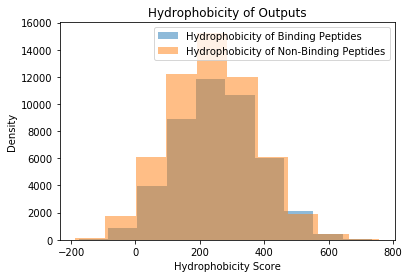

In [20]:
plt.hist(hydrophobicity_binding, bins=10, alpha=0.5, label='Hydrophobicity of Binding Peptides')
plt.hist(hydrophobicity_free, bins=10 , alpha=0.5, label='Hydrophobicity of Non-Binding Peptides')
plt.ylabel("Density")
plt.xlabel("Hydrophobicity Score")
plt.title('Hydrophobicity of Outputs')
plt.legend()
plt.show()

## Arginine content

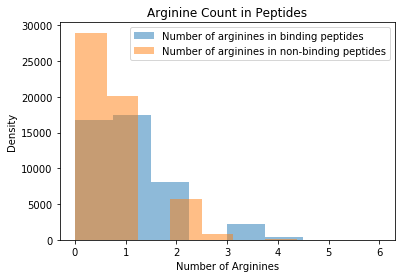

In [21]:
# Arginine content
plt.hist(arginine_binding, bins=8, alpha=0.5, label='Number of arginines in binding peptides')
plt.hist(arginine_free, bins=8 , alpha=0.5, label='Number of arginines in non-binding peptides')
plt.ylabel("Density")
plt.xlabel("Number of Arginines")
plt.title('Arginine Count in Peptides')
plt.legend()
plt.show()

## GC Content

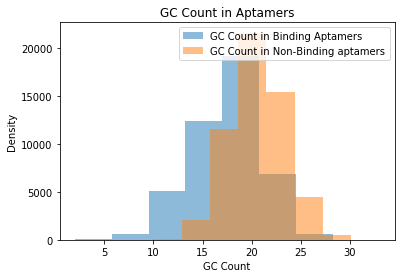

In [22]:
plt.hist(gc_binding, bins=8, alpha=0.5, label='GC Count in Binding Aptamers')
plt.hist(gc_free, bins=8 , alpha=0.5, label='GC Count in Non-Binding aptamers')
plt.ylabel("Density")
plt.xlabel("GC Count")
plt.title('GC Count in Aptamers')
plt.legend()
plt.show()

## Sequence Similarity

### Similarity to train set: aptamers that are from our dataset and generated

In [23]:
dataset_binding_similarity = []
generated_binding_similarity = []

# For aptamers in our dataset
for i, apt in enumerate(tqdm.tqdm(dataset_aptamers_binding)):
    max_score_train = 0
    for (train_apt, train_pep) in S_train[:10000]:
        # 2 points for matching, -1 points for mismatch, -2 for opening gap, -0.5 for continuing a gap
        sequence_similarity = pairwise2.align.globalms(apt, train_apt, 2, -1, -3, -1, score_only=True)
        max_score_train = max(max_score_train, sequence_similarity)
    dataset_binding_similarity.append(max_score_train)

# Generated    
for i, apt in enumerate(tqdm.tqdm(generated_aptamers_binding)):
    max_score_train = 0
    for (train_apt, train_pep) in S_train[:10000]:
        # 2 points for matching, -1 points for mismatch, -2 for opening gap, -0.5 for continuing a gap
        sequence_similarity = pairwise2.align.globalms(apt, train_apt, 2, -1, -3, -1, score_only=True)
        max_score_train = max(max_score_train, sequence_similarity)
    generated_binding_similarity.append(max_score_train)

100%|██████████| 7781/7781 [1:11:44<00:00,  1.81it/s]


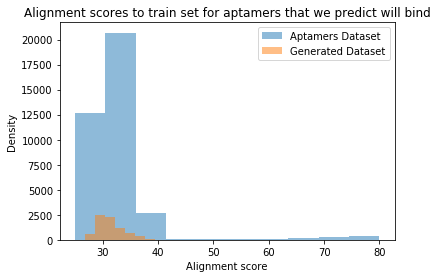

In [24]:
plt.hist(dataset_binding_similarity, bins=10, alpha=0.5, label="Aptamers Dataset")
plt.hist(generated_binding_similarity, bins=10, alpha=0.5, label="Generated Dataset")
plt.ylabel("Density")
plt.xlabel("Alignment score")
plt.title('Alignment scores to train set for aptamers that we predict will bind')
plt.legend()
plt.show()

### Similarity to train set: peptides that are from our dataset and generated

In [ ]:
dataset_binding_similarity = []
generated_binding_similarity = []

# For peptides in our dataset
for i, pep in enumerate(tqdm.tqdm(dataset_peptides_binding)):
    max_score_train = 0
    for (train_apt, train_pep) in S_train[:10000]:
        # 2 points for matching, -1 points for mismatch, -2 for opening gap, -0.5 for continuing a gap
        sequence_similarity = pairwise2.align.globalms(pep, train_pep, 2, -1, -2, -0.5, score_only=True)
        max_score_train = max(max_score_train, sequence_similarity)
    dataset_binding_similarity.append(max_score_train)

# Generated    
for i, pep in enumerate(tqdm.tqdm(generated_peptides_binding)):
    max_score_train = 0
    for (train_apt, train_pep) in S_train[:10000]:
        # 2 points for matching, -1 points for mismatch, -2 for opening gap, -0.5 for continuing a gap
        sequence_similarity = pairwise2.align.globalms(pep, train_pep, 2, -1, -2, -0.5, score_only=True)
        max_score_train = max(max_score_train, sequence_similarity)
    generated_binding_similarity.append(max_score_train)

  6%|▌         | 2277/37134 [13:00<3:14:18,  2.99it/s]

In [ ]:
plt.hist(dataset_binding_similarity, bins=10, alpha=0.5, label="Aptamers Dataset")
plt.hist(generated_binding_similarity, bins=10, alpha=0.5, label="Generated Dataset")
plt.ylabel("Density")
plt.xlabel("Alignment score")
plt.title('Alignment scores to train set for peptides that we predict will bind')
plt.legend()
plt.show()

### Mfold 

In [ ]:
# Look at free energy for aptamers_binding and aptamers_free

# Generate a fasta file


# mFold outputs
